In [4]:
import gym
import copy
from gym.wrappers.monitoring.video_recorder import VideoRecorder  # records videos of episodes
from gym.wrappers import FrameStack
import numpy as np
import matplotlib.pyplot as plt  # Graphical library
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Configuring Pytorch
from collections import namedtuple, deque
from itertools import count
import math
import random

In [12]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

#dont change
class ReplayBuffer(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#dont change
class DQN(nn.Module):

    def __init__(self, inputs, outputs, num_hidden, hidden_size):
        super(DQN, self).__init__()
        self.input_layer = nn.Linear(inputs, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden-1)])
        self.output_layer = nn.Linear(hidden_size, outputs)
    
    def forward(self, x):
        x.to(device)

        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        return self.output_layer(x)


class FrameStacking(gym.Wrapper):
    """Return only every 4th frame"""
    def __init__(self, env, k):
        super(FrameStacking, self).__init__(env)
        self._obs_buffer = deque([], maxlen=k)
        self._skip       = k
        self._prev_done  = False

    @property
    def _k_states(self):
        return torch.stack(list(self._obs_buffer)).reshape(-1).unsqueeze(0)
    
    def reset_buffer(self):
        self._obs_buffer = deque([], maxlen=self._skip)


class CartpoleAgent():
    def __init__(self, NUM_EPISODES, BATCH_SIZE, GAMMA, TARGET_UPDATE_FREQ, 
                 NUM_FRAMES, NUM_HIDDEN_LAYERS, SIZE_HIDDEN_LAYERS, REPLAY_BUFFER, LR,
                 EPS_START, EPS_END, EPS_DECAY, REWARD_TARGET):

        #initialisation attributes
        self.reward_target = REWARD_TARGET
        self.reward_threshold = 0
        self.num_episodes = NUM_EPISODES
        self.batch_size = BATCH_SIZE
        self.gamma = GAMMA
        self.target_update_freq = TARGET_UPDATE_FREQ
        self.eps_start = EPS_START
        self.eps_end = EPS_END
        self.eps_decay = EPS_DECAY
        self.k = NUM_FRAMES
        self.curr_episode = 0
        self.train_rewards = []

        self.epsilon = self.eps_start
        self.epsilon_delta = (self.epsilon - self.eps_end)/self.reward_target

        #Get number of states and actions from gym action space
        env = gym.make("CartPole-v1")
        env.reset()
        self.state_dim = len(env.state)    #x, x_dot, theta, theta_dot
        self.n_actions = env.action_space.n
        env.close()

        self.input_dim = int(self.state_dim*self.k) #define input size of DQN

        #define policy and target networks, as well as optimizer and replay buffer
        self.policy_net = DQN(self.input_dim, self.n_actions, NUM_HIDDEN_LAYERS, SIZE_HIDDEN_LAYERS).to(device)
        self.target_net = DQN(self.input_dim, self.n_actions, NUM_HIDDEN_LAYERS, SIZE_HIDDEN_LAYERS).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
                            
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        self.memory = ReplayBuffer(REPLAY_BUFFER)


    def select_action(self, k_states):
        """"""
        sample = random.random()
        if sample > self.epsilon:
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.policy_net(k_states).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)


    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: torch.sum(s[0][-self.k:]).absolute().item() > 0, batch.next_state)), device=device, dtype=torch.bool)
        
        # Can safely omit the condition below to check that not all states in the
        # sampled batch are terminal whenever the batch size is reasonable and
        # there is virtually no chance that all states in the sampled batch are 
        # terminal
        if sum(non_final_mask) > 0:
            non_final_next_states = torch.cat([s for s in batch.next_state if torch.sum(s[0][-self.k:]).absolute().item() > 0])
        else:
            non_final_next_states = torch.empty(0,self.state_dim).to(device)

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=device)
        
        with torch.no_grad():
            # Once again can omit the condition if batch size is large enough
            if sum(non_final_mask) > 0:
                next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
            else:
                next_state_values = torch.zeros_like(next_state_values)

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute loss
        loss_func = nn.MSELoss()
        loss = loss_func(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()

        # Limit magnitude of gradient for update step
        #for param in self.policy_net.parameters():
        #    param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

    def train(self):
        """"""
        env = gym.make("CartPole-v1")
        steps = 0
        stack_frames = FrameStacking(env, self.k) #define frame stacking framework

        for i_episode in tqdm.tqdm(range(self.num_episodes)):
            rewards = 0
            #if i_episode % 20 == 0:
                #print("episode ", i_episode, "/", self.num_episodes)

            env.reset() #reset environment
            state = torch.tensor(env.state).float().unsqueeze(0).to(device)
            for _ in range(self.k): # Added
                stack_frames._obs_buffer.append(state) # Added

            for _ in count():
                #process frames to pass as input to DQN
                k_states = stack_frames._k_states
                action = self.select_action(k_states) 
                _, reward, done, _ = env.step(action.item()) #take step following epsilon-greedy policy

                rewards += reward
                reward = torch.tensor([reward], device=device)

                # Observe new state
                if not done:
                    next_state = torch.tensor(env.state).float().unsqueeze(0).to(device)
                else:
                    next_state = torch.zeros(1, self.state_dim)

                #store new state in frames buffer and process frames to pass as input to DQN
                stack_frames._obs_buffer.append(next_state) 
                next_k_states = stack_frames._k_states

                #Store the transition in memory
                self.memory.push(k_states, action, next_k_states, reward) 

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                self.optimize_model()

                if done:
                    break

                # Select and perform an action
                steps += 1

            stack_frames.reset_buffer() #reset frame stack memory

            # Update the target network, copying all weights and biases in DQN
            if i_episode % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            #implement reward-based decay
            if self.epsilon > self.eps_end and rewards > self.reward_threshold:
                self.epsilon -= self.epsilon_delta
                self.reward_threshold += 1

            self.train_rewards.append(rewards) #append episode reward to list
            self.curr_episode += 1

        print("Complete")
        env.close() #close environment


    def test(self):
        """run an episode with trained agent and record video"""

        env = gym.make("CartPole-v1")
        file_path = 'video.mp4'
        recorder = VideoRecorder(env, file_path)

        env.reset()
        done = False

        stack_frames = FrameStacking(env, self.k) #define frame stacking framework

        state = torch.tensor(env.state).float().unsqueeze(0).to(device)
        for _ in range(self.k): # Added
            stack_frames._obs_buffer.append(state) # Added

        duration = 0

        while not done:
            recorder.capture_frame()
            # Select and perform an action
            k_states = stack_frames._k_states
            action = self.select_action(k_states) 
            _, reward, done, _ = env.step(action.item()) #take step following epsilon-greedy policy
            duration += 1

            next_state = torch.tensor(env.state).float().unsqueeze(0).to(device)
            
            #store new state in frames buffer and process frames to pass as input to DQN
            stack_frames._obs_buffer.append(next_state) 

        env.close()
        recorder.close()

        print("Episode duration: ", duration)

    def tune_params(self):
        """"""
        pass

    def save_fig(self):
        """"""
        pass
    
    def plot_rewards(self):
        """Plot the total non-discounted sum of rewards across the episodes (i.e duration of each episode in steps)."""
        epochs = np.linspace(0, len(self.train_rewards), len(self.train_rewards))

        plt.figure()
        plt.grid()
        plt.plot(epochs, self.train_rewards, label="Total Non-Discounted Rewards")
        plt.axhline(y=self.reward_target, color='black', linestyle='-', label="Reward target")
        #plt.plot(epochs, rewards_list, "b.", markersize=3)
        #plt.plot(epochs, np.poly1d(np.polyfit(epochs, rewards_list, 1))(epochs), "r")
        plt.xlabel("Episodes")
        plt.ylabel("Total Non-Discounted Reward")
        plt.legend(loc="upper left")
        plt.show()


In [23]:
#define hyperparameters for agent
NUM_EPISODES = 1000
BATCH_SIZE = 32
GAMMA = 1.0
TARGET_UPDATE_FREQ = 10
NUM_FRAMES = 1
NUM_HIDDEN_LAYERS = 2
SIZE_HIDDEN_LAYERS = 150
REPLAY_BUFFER = 40000
LR = 0.0001
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 200
REWARD_TARGET = 200

episode  0 / 500
episode  20 / 500
episode  40 / 500
episode  60 / 500
episode  80 / 500
episode  100 / 500
episode  120 / 500
episode  140 / 500
episode  160 / 500
episode  180 / 500
episode  200 / 500
episode  220 / 500
episode  240 / 500
episode  260 / 500
episode  280 / 500
episode  300 / 500
episode  320 / 500
episode  340 / 500
episode  360 / 500
episode  380 / 500
episode  400 / 500
episode  420 / 500
episode  440 / 500
episode  460 / 500
episode  480 / 500
Complete


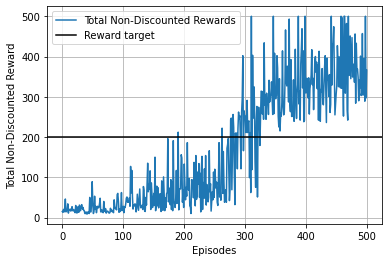

In [3]:
CP_agent = CartpoleAgent(NUM_EPISODES, BATCH_SIZE, GAMMA, TARGET_UPDATE_FREQ, 
                            NUM_FRAMES, NUM_HIDDEN_LAYERS, SIZE_HIDDEN_LAYERS, 
                            REPLAY_BUFFER, LR, EPS_START, EPS_END, EPS_DECAY, REWARD_TARGET)

CP_agent.train()
CP_agent.plot_rewards()
#CP_agent.test()

In [21]:
def plot_replications(mean_rewards, std_rewards):
    """"""
    episodes = np.arange(len(mean_rewards))

    plt.figure(figsize=(20,20))
    plt.grid()
    plt.plot(episodes, mean_rewards, "b", label="Mean")
    plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards, color="b", alpha=0.4, label=r"$\sigma$")
    plt.xlabel("Episode")
    plt.ylabel("Mean Total Non-Discounted \nReward")
    plt.legend(loc="upper left")
    plt.show();
    

def replicate_CPAgent(N_REPLICATIONS,NUM_EPISODES, BATCH_SIZE, GAMMA, TARGET_UPDATE_FREQ, 
                      NUM_FRAMES, NUM_HIDDEN_LAYERS, SIZE_HIDDEN_LAYERS, 
                      REPLAY_BUFFER, LR, EPS_START, EPS_END, EPS_DECAY, REWARD_TARGET):
    """"""
    replication_rewards = []
    for i in range(N_REPLICATIONS):
        print(f"Replication {i+1}")
        CP_agent = CartpoleAgent(NUM_EPISODES, BATCH_SIZE, GAMMA, TARGET_UPDATE_FREQ, 
                                 NUM_FRAMES, NUM_HIDDEN_LAYERS, SIZE_HIDDEN_LAYERS, 
                                 REPLAY_BUFFER, LR, EPS_START, EPS_END, EPS_DECAY, REWARD_TARGET)
    
        CP_agent.train() #train agent
        replication_rewards.append(CP_agent.train_rewards)

    mean_rewards = np.mean(np.array(replication_rewards), axis=0)
    std_rewards = np.std(np.array(replication_rewards), axis=0)

    return mean_rewards, std_rewards

In [24]:
N_REPLICATIONS = 20
mean_rewards, std_rewards = replicate_CPAgent(N_REPLICATIONS,NUM_EPISODES, BATCH_SIZE, GAMMA, TARGET_UPDATE_FREQ, 
                                              NUM_FRAMES, NUM_HIDDEN_LAYERS, SIZE_HIDDEN_LAYERS, 
                                              REPLAY_BUFFER, LR, EPS_START, EPS_END, EPS_DECAY, REWARD_TARGET)

Replication 1


100%|██████████| 1000/1000 [08:21<00:00,  1.99it/s]


Complete
Replication 2


100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s]


Complete
Replication 3


100%|██████████| 1000/1000 [10:13<00:00,  1.63it/s]


Complete
Replication 4


 91%|█████████ | 911/1000 [09:01<01:15,  1.18it/s]

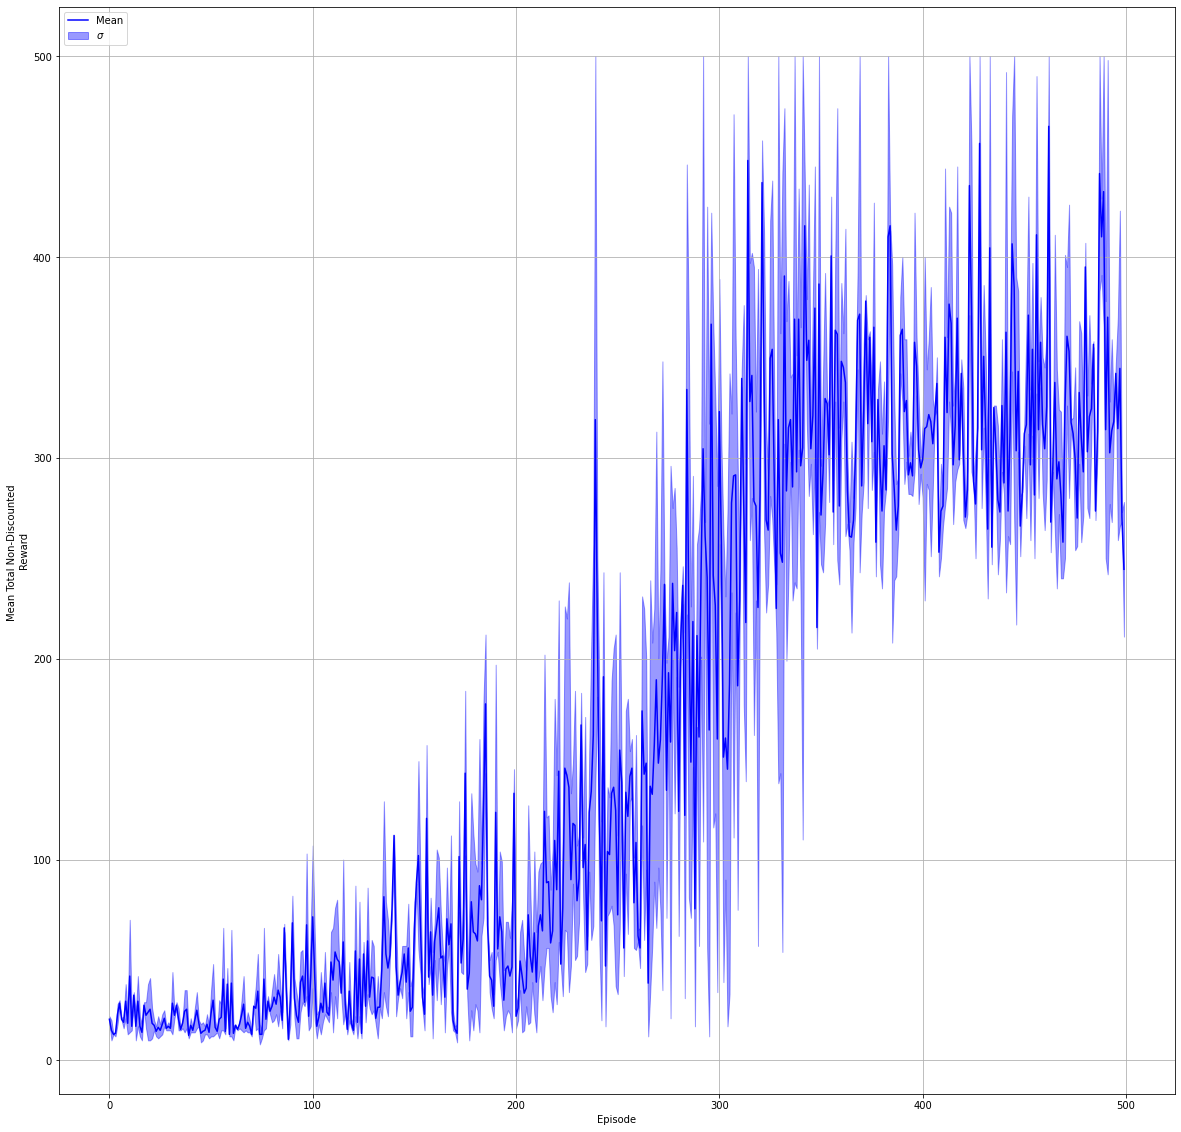

In [22]:
plot_replications(mean_rewards, std_rewards)